In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [2]:
# read csv
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

# look at first 5 rows, transposed. 
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [3]:
df.shape

(239177, 7)

In [4]:
df.isna().sum()

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [5]:
df['dt'] = pd.to_datetime(df.dt)
df.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
df= df.set_index('dt').sort_index()
df.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,7.648,1.749,Paris,France,49.03N,2.45E
1743-11-01,-1.854,1.734,Montreal,Canada,45.81N,72.69W


In [7]:
# add month and year columns
df['month'] = df.index.month_name()
df['year'] = df.index.year

In [8]:
df.head(2)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,7.648,1.749,Paris,France,49.03N,2.45E,November,1743
1743-11-01,-1.854,1.734,Montreal,Canada,45.81N,72.69W,November,1743


In [9]:
df['City'].value_counts()

Paris         3239
London        3239
Istanbul      3239
Montreal      3239
Chicago       3239
              ... 
Kano          1893
Cape Town     1881
Durban        1881
Umm Durman    1857
Lima          1591
Name: City, Length: 100, dtype: int64

In [10]:
df = df.loc[df['City'] == 'Chicago']
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W,November,1743
1743-12-01,NaN,NaN,Chicago,United States,42.59N,87.27W,December,1743
1744-01-01,NaN,NaN,Chicago,United States,42.59N,87.27W,January,1744
1744-02-01,NaN,NaN,Chicago,United States,42.59N,87.27W,February,1744
1744-03-01,NaN,NaN,Chicago,United States,42.59N,87.27W,March,1744


### Explore

<AxesSubplot:xlabel='dt'>

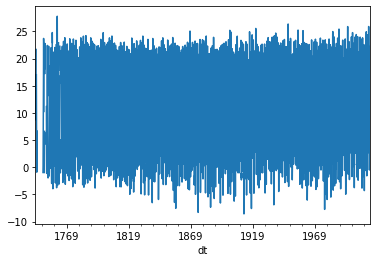

In [11]:
df.AverageTemperature.plot()

In [12]:
df=df.dropna()
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W,November,1743
1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W,April,1744
1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W,May,1744


In [13]:
# After dropping nulls, find the shape
df.shape

(3141, 8)

<AxesSubplot:xlabel='dt'>

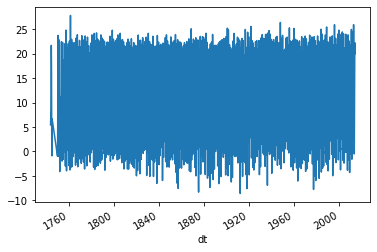

In [14]:
df.AverageTemperature.plot()

<AxesSubplot:xlabel='year'>

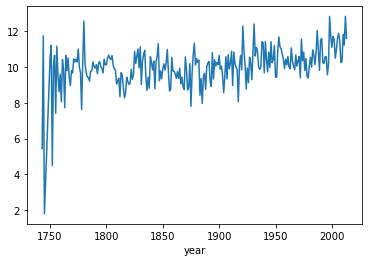

In [15]:
df.groupby('year').AverageTemperature.mean().plot()

In [16]:
df_split = df[['AverageTemperature', 'AverageTemperatureUncertainty']]
df_split

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,5.436,2.205
1744-04-01,8.766,2.357
1744-05-01,11.605,2.102
1744-06-01,17.965,1.989
1744-07-01,21.680,1.786
...,...,...
2013-05-01,13.734,0.863
2013-06-01,17.913,0.669
2013-07-01,21.914,0.322


### Split

In [17]:
# set train size to be 50% of total 
train_size = int(len(df_split) * 0.5)
train_size

1570

In [18]:
# set validate size to be 30% of total 
validate_size = int(len(df_split) * 0.3)
validate_size

942

In [19]:
# set test size to be number of rows remaining. 
test_size = int(len(df_split) - train_size - validate_size)
test_size

629

In [20]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index

2512

In [21]:
# train will go from 0 to 911
train = df_split[:train_size]
# validate will go from 912 to 1458
validate = df_split[train_size:validate_end_index]
# test will include 1459 to the end
test = df_split[validate_end_index:]

Verify splits

In [22]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df_split))

True


In [23]:
print(df_split.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty
dt                                                           
1743-11-01                True                           True


In [24]:
pd.concat([train.tail(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1882-10-01,14.699,0.560
1882-11-01,7.209,0.751


In [25]:
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1961-04-01,5.141,0.322
1961-05-01,10.005,0.138


In [26]:
pd.concat([test.tail(1), df_split.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2013-09-01,19.977,1.033
2013-09-01,19.977,1.033


Let's plot our data first, viewing where the data is split into train and test.

In [27]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty'], dtype='object')

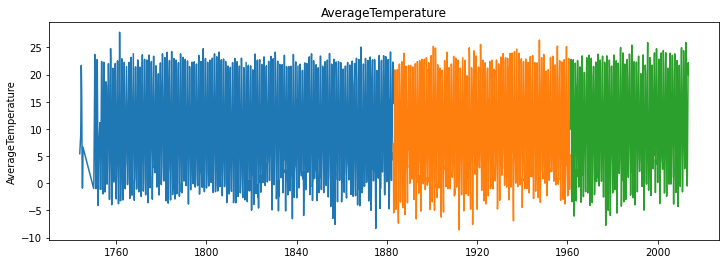

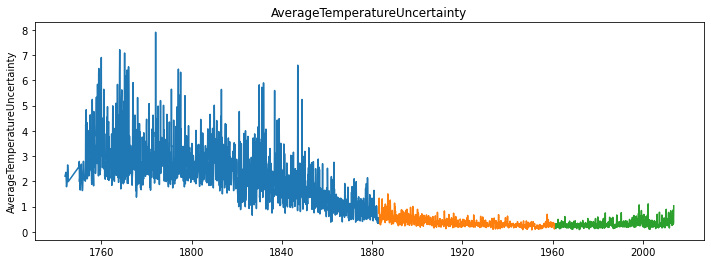

In [28]:
for col in train.columns.tolist()[0:2]:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [36]:
df_split.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
dtype: int64

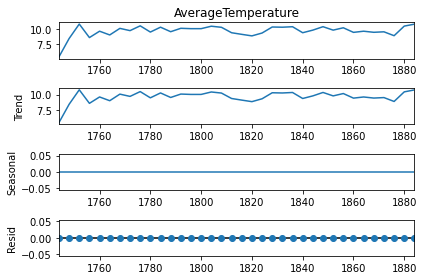

In [37]:
# Seasonal Decomposition

sm.tsa.seasonal_decompose(train.AverageTemperature.resample('4Y').mean()).plot()
None

Takeaways:
    
 * After 1880 the temperature was more certain due to evolving technology to predict weather
 * There is more average temperatiure uncetainty in our train dataset than the others
 * Average temperatures are more static over time

### Model